#Imports


In [32]:
%%capture
!pip install kaggle
!pip install optuna

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler # φέρνουμε τον StandarScaler ως transformer που έχει .transform kai ΄όχι ως scale()
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC, SVC

import optuna
from collections import defaultdict 

import time
import os

from google.colab import drive

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

#Μέρος 1. UCI Dataset


##Εισαγωγή Dataset

In [3]:
#%%capture

!wget --no-check-certificate 'https://www.dropbox.com/s/j0qzrchft16mhx7/dermatology.data?dl=0' -o dermatology_data
!wget --no-check-certificate 'https://www.dropbox.com/s/e187frer1zzwyag/dermatology.names?dl=0' -o dermatology_names

In [4]:
df_uci = pd.read_csv('/content/dermatology.data?dl=0', sep = ',')

cols_names = ['erythema',
      'scaling',
      'definite borders',
      'itching',
      'koebner phenomenon',
      'polygonal papules',
      'follicular papules',
      'oral mucosal involvement',
      'knee and elbow involvement',
      'scalp involvement',
      'family history',
      'melanin incontinence',
      'eosinophils in the infiltrate',
      'PNL infiltrate',
      'fibrosis of the papillary dermis',
      'exocytosis',
      'acanthosis',
      'hyperkeratosis',
      'parakeratosis',
      'clubbing of the rete ridges',
      'elongation of the rete ridges',
      'thinning of the suprapapillary epidermis',
      'spongiform pustule',
      'munro microabcess',
      'focal hypergranulosis',
      'disappearance of the granular layer',
      'vacuolisation and damage of basal layer',
      'spongiosis',
      'saw-tooth appearance of retes',
      'follicular horn plug',
      'perifollicular parakeratosis',
      'inflammatory monoluclear inflitrate',
      'band-like infiltrate', 
      'Age',
      'labels']

df_uci.columns = cols_names

In [5]:
df_uci

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,family history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,labels
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,1
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,3
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,1
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,3
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,25,4
361,3,2,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,36,4
362,3,2,2,2,3,2,0,2,0,0,0,2,2,0,0,3,3,0,0,0,0,0,0,0,3,0,3,0,3,0,0,2,3,28,3
363,2,1,3,1,2,3,0,2,0,0,0,2,0,0,0,3,2,0,0,0,0,0,0,0,3,0,2,0,1,0,0,2,3,50,3


### Επισκόπηση

**Σύντομη παρουσίαση του dataset δηλαδή ποιο είναι το πρόβλημα που περιγράφει**

To συγκεκριμένο dataset περιγράφει την διάγνωση των ερυθηµατολεπιδωδών πλακωδών(erythemato-squamous) ασθενειών. Οι ασθένειες αυτού του τύπου έχουν κάποια κοινά χαρακτηριστικά, όπως ερύθημα και "scaling" με μικρές διαφορές, γεγονός που καθιστά δύσκολη τη διάγνωση, κρίνοντας απαραίτητη τη βιοψία. Για την αποφυγή αυτού, δημιουργούμε το συγκεκριμένο μοντέλο, το οποίο λαμβάνοντας υπ' όψιν 34 χαρακτηριστικά του ασθενή προβλέπει από ποια από τις 6 ασθένειες πάσχει.

**Χρειάστηκε να κάνετε μετατροπές στα αρχεία plain text για την εισαγωγή του; αν ναι, ποιες είναι αυτές;**

Επειδή στο αρχείο .data δεν συμπεριλαμβανόταν τα ονόματα των "attributes" χρείαστηκε να τα προσθέσουμε χειροκίνητα με βάση το αρχείο .names.

**Δώστε το πλήθος δειγμάτων και χαρακτηριστικών, και το είδος όλων των χαρακτηριστικών. Υπάρχουν μη διατεταγμένα χαρακτηριστικά και ποια είναι αυτά;**



In [6]:
print('Number of instances = ' + str(df_uci.shape[0]))
print('Number of attributes = ' + str(df_uci.shape[1]))
print('Type of attributes: \n' + str(df_uci.dtypes))

Number of instances = 365
Number of attributes = 35
Type of attributes: 
erythema                                     int64
scaling                                      int64
definite borders                             int64
itching                                      int64
koebner phenomenon                           int64
polygonal papules                            int64
follicular papules                           int64
oral mucosal involvement                     int64
knee and elbow involvement                   int64
scalp involvement                            int64
family history                               int64
melanin incontinence                         int64
eosinophils in the infiltrate                int64
PNL infiltrate                               int64
fibrosis of the papillary dermis             int64
exocytosis                                   int64
acanthosis                                   int64
hyperkeratosis                               int64
parakerat

Παρατηρούμε πως όλα τα χαρακτηριστικά είναι διατεταγμένα.

**Υπάρχουν επικεφαλίδες; Αρίθμηση γραμμών;**

Όχι δεν υπάρχουν επικεφαλίδες στα raw data αλλά προσθέθηκαν manually από το αρχείο .names.

Δεν υπάρχει αρίθμηση γραμμών και συμπληρώνεται αυτόματα από την βιβλιοθήκη pandas.

**Ποιες είναι οι ετικέτες των κλάσεων και σε ποια κολόνα βρίσκονται;**

Οι ετικέτες των κλάσεων είναι οι εξής:

|Class code | Class|
| ----- | --------  |
| 1 | psoriasis |
| 2 | seboreic dermatitis |
| 3 | lichen planus |
| 4 | pityriasis rosea |
| 5 | cronic dermatitis |
| 6 | pityriasis rubra pilaris  |

και βρίσκονται στο column ['labels'], δηλαδή στην στήλη 35 του dataframe.

**Υπάρχουν απουσιάζουσες τιμές; Πόσα είναι τα δείγματα με απουσιάζουσες τιμές και ποιο το ποσοστό τους επί του συνόλου;**

Υπάρχουν απουσιάζουσες τιμές στη στήλη ['Age']


In [7]:
num_of_missing_data = df_uci.shape[0] - df_uci.drop(df_uci.loc[df_uci.values == '?'].index).shape[0]

print('Number of data with missing attributes = ' + str(num_of_missing_data))
print('Data with Missing attributes percentage = ' + str(round((num_of_missing_data / df_uci.shape[0]) * 100, 2)) + '%')

Number of data with missing attributes = 8
Data with Missing attributes percentage = 2.19%


**Ποιος είναι το πλήθος των κλάσεων και τα ποσοστά δειγμάτων τους επί του συνόλου; Αν θεωρήσουμε ότι ένα dataset είναι μη ισορροπημένο αν μια οποιαδήποτε κλάση είναι 1.5 φορά πιο συχνή από κάποια άλλη (60%-40% σε binary datasets) εκτιμήστε αν το dataset είναι ισορροπημένο ή όχι.**

In [8]:
num_of_classes = len(df_uci['labels'].unique())

psoriasis = round((len(df_uci[df_uci.labels == 1]) / df_uci.shape[0]) * 100, 2)
seboreic_dermatitis = round((len(df_uci[df_uci.labels == 2]) / df_uci.shape[0]) * 100, 2)
lichen_planus = round((len(df_uci[df_uci.labels == 3]) / df_uci.shape[0]) * 100, 2)
pityriasis_rosea = round((len(df_uci[df_uci.labels == 4]) / df_uci.shape[0]) * 100, 2)
cronic_dermatitis = round((len(df_uci[df_uci.labels == 5]) / df_uci.shape[0]) * 100, 2)
pityriasis_rubra_pilaris = round((len(df_uci[df_uci.labels == 6]) / df_uci.shape[0]) * 100, 2)

print('Total number of classes = ' + str(num_of_classes))
print('Percentage of psoriasis = ' + str(psoriasis) + ' %')
print('Percentage of seboreic_dermatitis = ' + str(seboreic_dermatitis) + ' %')
print('Percentage of lichen_planus = ' + str(lichen_planus) + ' %')
print('Percentage of pityriasis_rosea = ' + str(pityriasis_rosea) + ' %')
print('Percentage of cronic_dermatitis = ' + str(cronic_dermatitis) + ' %')
print('Percentage of pityriasis_rubra_pilaris = ' + str(pityriasis_rubra_pilaris) + ' %')

Total number of classes = 6
Percentage of psoriasis = 30.68 %
Percentage of seboreic_dermatitis = 16.44 %
Percentage of lichen_planus = 19.73 %
Percentage of pityriasis_rosea = 13.42 %
Percentage of cronic_dermatitis = 14.25 %
Percentage of pityriasis_rubra_pilaris = 5.48 %


In [9]:
a = [psoriasis, seboreic_dermatitis, lichen_planus, pityriasis_rosea, cronic_dermatitis, pityriasis_rubra_pilaris]
if min(a) * 1.5 < max(a):
    print('The dataset is unbalanced')
else:
    print('The dataset is balanced')

The dataset is unbalanced


## Προετοιμασία

Όπως φαίνεται και παραπάνω, οι τιμές που απουσιάζουν αντιστοίχουν σε 8 δείγματα (2% συνολικού dataset). Επομένως, επιλέγουμε να αφαιρέσουμε τα συγκεκριμένα δείγματα από το dataset και, στη συνέχεια, να κάνουμε τον διαχωρισμό σε train και test set.

In [10]:
df_uci = df_uci.drop(df_uci.loc[df_uci.Age == '?'].index).astype(int)
data = df_uci.values
features = data[:,:-1]
labels = data[:,-1]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True)

print(f'Train data shape: {x_train.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Test data shape: {x_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Train data shape: (249, 34)
Train labels shape: (249,)
Test data shape: (108, 34)
Test labels shape: (108,)


In [11]:
train_label_count = np.bincount(y_train)
if min(train_label_count[1:]) * 1.5 < max(train_label_count[1:]):
    print('Train set is unbalanced')
else:
    print('Train se is balanced')
print(f'Labels count: {train_label_count[1:]}')

Train set is unbalanced
Labels count: [79 37 56 31 33 13]


Ελέγχουμε εάν το το train set είναι ισορροπημένο και παρατηρούμε ότι δεν είναι.Για τον λόγο αυτό στο στάδιο της βελτιστοποίησης των ταξινομητών μας θα το εξισορροπήσουμε με υποδειγματοληψία (undersampling) και υπερδειγματοληψία (oversampling) μέσω ενός Pipeline. Αυτό το κάνουμε καθώς υπάρχει μεγάλη απόκλιση μεταξύ του μέγιστου και του ελάχιστου αριθμού δειγμάτων μίας κλάσης (Μέγιστος: 78, Ελάχιστος: 15). 

Στο data set δεν υπήρχαν εξ αρχής κατηγορικά ή/και μη διατεταγμένα χαρακτηριστικά, οπότε δεν χρειάστηκε περαιτέρω επεξεργασία.

## Ταξινόμηση

### Επίδοση out-of-the-box

In [12]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")
gnb = GaussianNB()
knn = KNeighborsClassifier()
logisticRegr = LogisticRegression()

In [19]:
uci_accuracy = {}
models_names = ['uniform (random)','most frequent label', 'stratified', 'gaussian naive bayes', 'k-NN', 'logistic regression']
models = [dc_uniform, dc_most_frequent, dc_stratified, gnb, knn, logisticRegr]
for model_name, model in zip(models_names, models):
  model = model.fit(x_train, y_train)
  preds = model.predict(x_test)
  uci_accuracy[model_name] = (model.score(x_test, y_test), f1_score(preds, y_test, average='macro'))

print("Classification Accuracy on the Dataset (30% test set)\n")
sorted_accuracy = [(k[0], uci_accuracy[k[0]]) for k in sorted(uci_accuracy.items(), key=lambda x: x[1][0], reverse=True)]
sorted_f1 = [(k[0], uci_accuracy[k[0]]) for k in sorted(uci_accuracy.items(), key=lambda x: x[1][1], reverse=True)]

for k, v in sorted_accuracy:
  print('\033[1m'+ k +'\033[0m' )
  print(f'Accuracy: {v[0]}')
  print(f'f1 (macro): {v[1]} \n')

print('Depending on accuracy: ')
for k, _ in sorted_accuracy:
  print('\033[1m'+ k +'\033[0m' , end = " ")
  if k != sorted_accuracy[-1][0]:
    print(">", end = " ")


print('\n \nDepending on f1: ')
for k, _ in sorted_f1:
  print('\033[1m'+ k +'\033[0m' , end = " ")
  if k != sorted_f1[-1][0]:
    print(">", end = " ")
print()

Classification Accuracy on the Dataset (30% test set)

logistic regression
Accuracy: 0.9629629629629629
f1 (macro): 0.9652406417112299 

gaussian naive bayes
Accuracy: 0.8703703703703703
f1 (macro): 0.8707465873560588 

k-NN
Accuracy: 0.8055555555555556
f1 (macro): 0.8038235038235038 

most frequent label
Accuracy: 0.2962962962962963
f1 (macro): 0.07619047619047618 

uniform (random)
Accuracy: 0.25925925925925924
f1 (macro): 0.1690809706489149 

stratified
Accuracy: 0.23148148148148148
f1 (macro): 0.12098596544560976 

Depending on accuracy: 
logistic regression > gaussian naive bayes > k-NN > most frequent label > uniform (random) > stratified 
 
Depending on f1: 
logistic regression > gaussian naive bayes > k-NN > uniform (random) > stratified > most frequent label 


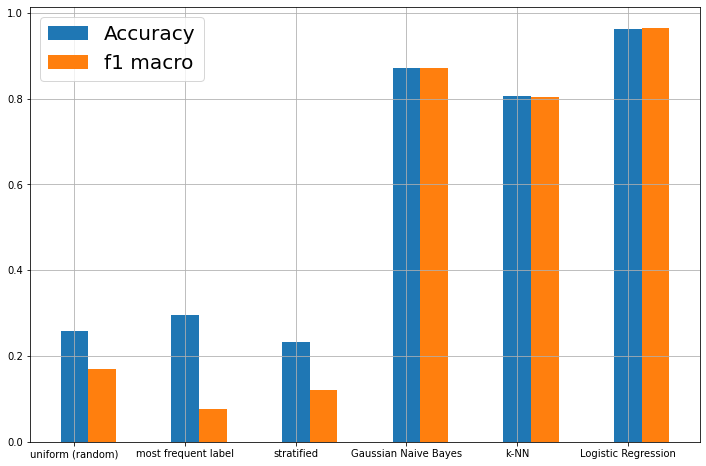

In [20]:
fig = plt.subplots(figsize=(12,8))
accuracy = [x for (x,_) in list(uci_accuracy.values())]
f1 = [x for (_,x) in list(uci_accuracy.values())]

barWidth = 0.25

bar_acc = np.arange(len(accuracy))-barWidth/2
bar_f1 = [x+barWidth for x in bar_acc]
models_names = ['uniform (random)','most frequent label','stratified', 'Gaussian Naive Bayes', 'k-NN', 'Logistic Regression']

plt.bar(bar_acc, accuracy,width=barWidth, label='Accuracy')
plt.bar(bar_f1, f1,width=barWidth, label='f1 macro')
plt.xticks(np.array(bar_acc), np.array(models_names))
plt.legend(loc=2,prop={'size': 20})
plt.grid(True)
plt.show()

In [21]:
out_of_the_box_df = pd.DataFrame()
out_of_the_box_df['Accuracy'] = pd.Series(accuracy)
out_of_the_box_df['F1 score (macro)'] = pd.Series(f1)
out_of_the_box_df.index = models_names

In [22]:
out_of_the_box_df

,Accuracy,F1 score (macro)
uniform (random),0.259259,0.169081
most frequent label,0.296296,0.076190
stratified,0.231481,0.120986
Gaussian Naive Bayes,0.870370,0.870747
k-NN,0.805556,0.803824
Logistic Regression,0.962963,0.965241


Δεν υλοποιήθηκαν constant 1, 2,... dummy classifiers, καθώς σε προβλήματα με πολλές διαφορετικές κλάσσεις, ο most frequent dummy classifier αποτελεί τον καλύτερο constant.

### Βελτιστοποίηση

Κατά την βελτιστοποίηση χρησιμοποιούμε ορισμό Pipelines (μέσω των οποίων γίνεται και η προεπεξεργασία της εισόδου και το oversampling-undersampling), και Gridsearch για την εύρεση των βέλτιστων υπερπαραμέτρων.

In [23]:
optimized = defaultdict(lambda: defaultdict(dict))
predictions = {}

#### Dummy Classifiers

In [24]:
models_names = ['uniform (random)','most frequent label','stratified']
models = [dc_uniform, dc_most_frequent, dc_stratified]
for model_name, model in zip(models_names, models):# αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς υπερ-παραμέτρους
  scaler = StandardScaler()
  under = RandomUnderSampler("all")
  over=RandomOverSampler("minority")

  # αρχικοποίηση του Pipeline
  pca = PCA()
  clf = model
  pipe = Pipeline(steps=[('scaler', scaler), ('o1', over), ('o2', over), ('o3', over), ('u', under), ('pca', pca), ('', model)])
  n_components = [10, 15, 20, 25, 30]
  
  for metric in ['f1_macro', 'accuracy']:
    estimator = GridSearchCV(pipe, dict(pca__n_components=n_components), cv=10, scoring=metric, n_jobs=-1) 
    start_time_fit = time.time()
    estimator.fit(x_train, y_train)
    time_fit = time.time() - start_time_fit
    start_time_pred = time.time()
    preds = estimator.predict(x_test)
    time_pred = time.time() - start_time_pred
    print(f'\033[1m Classifier: {model_name} \033[0m')
    print(f'Metric: \033[1m {metric} \033[0m')
    print(f'Elapsed Train Time: {time_fit}')
    print(f'Elapsed Test Time: {time_pred} \n')
    print(f'Accuracy: {accuracy_score(preds, y_test)}')
    met = 'macro'
    print(f'F1 score (macro): {f1_score(preds, y_test, average=met)}')

    print()
    #print(f'Best Estimator with GridSearchCV\n: {estimator.best_estimator_} \n')
    print(f'Best parameters: {estimator.best_params_}')
    print()

    optimized[model_name][metric] = {'accuracy': accuracy_score(preds, y_test),
                                     'f1': f1_score(preds, y_test, average=met),
                                     'train time': time_fit,
                                     'test time': time_pred}

 Classifier: uniform (random) 
Metric:  f1_macro 
Elapsed Train Time: 0.4323768615722656
Elapsed Test Time: 0.0004754066467285156 

Accuracy: 0.21296296296296297
F1 score (macro): 0.2070219850392264

Best parameters: {'pca__n_components': 20}

 Classifier: uniform (random) 
Metric:  accuracy 
Elapsed Train Time: 0.38788652420043945
Elapsed Test Time: 0.0005395412445068359 

Accuracy: 0.18518518518518517
F1 score (macro): 0.1896480083980084

Best parameters: {'pca__n_components': 30}

 Classifier: most frequent label 
Metric:  f1_macro 
Elapsed Train Time: 0.43361759185791016
Elapsed Test Time: 0.0004470348358154297 

Accuracy: 0.2962962962962963
F1 score (macro): 0.07619047619047618

Best parameters: {'pca__n_components': 10}

 Classifier: most frequent label 
Metric:  accuracy 
Elapsed Train Time: 0.3948366641998291
Elapsed Test Time: 0.0004825592041015625 

Accuracy: 0.2962962962962963
F1 score (macro): 0.07619047619047618

Best parameters: {'pca__n_components': 10}

 Classifier: str

#### Gaussian Naive Bayes

In [25]:
model_name = 'Gaussian Naive Bayes'
scaler = StandardScaler()
under = RandomUnderSampler("all")
over=RandomOverSampler("minority")

# αρχικοποίηση του Pipeline
pca = PCA()
clf = GaussianNB()
pipe = Pipeline(steps=[('scaler', scaler), ('o1', over), ('o2', over), ('o3', over), ('u', under), ('pca', pca), ('gnb', clf)])
n_components = [10, 15, 20, 25, 30]
for metric in ['f1_macro', 'accuracy']:
    estimator = GridSearchCV(pipe, dict(pca__n_components=n_components), cv=10, scoring=metric, n_jobs=-1) 
    start_time_fit = time.time()
    estimator.fit(x_train, y_train)
    time_fit = time.time() - start_time_fit
    start_time_pred = time.time()
    preds = estimator.predict(x_test)
    time_pred = time.time() - start_time_pred
    print(f'\033[1m Classifier: {model_name} \033[0m')
    print(f'Metric: \033[1m {metric} \033[0m')
    print(f'Elapsed Train Time: {time_fit}')
    print(f'Elapsed Test Time: {time_pred} \n')
    print(f'Accuracy: {accuracy_score(preds, y_test)}')
    met = 'macro'
    print(f'F1 score (macro): {f1_score(preds, y_test, average=met)}')

    print()
    #print(f'Best Estimator with GridSearchCV\n: {estimator.best_estimator_} \n')
    print(f'Best parameters: {estimator.best_params_}')
    print()

    optimized[model_name][metric] = {'accuracy': accuracy_score(preds, y_test),
                                     'f1': f1_score(preds, y_test, average=met),
                                     'train time': time_fit,
                                     'test time': time_pred}

    if metric == 'accuracy':
        predictions['Gaussian Naive Bayes'] = preds

 Classifier: Gaussian Naive Bayes 
Metric:  f1_macro 
Elapsed Train Time: 0.48435425758361816
Elapsed Test Time: 0.0009822845458984375 

Accuracy: 0.9444444444444444
F1 score (macro): 0.9493536551345882

Best parameters: {'pca__n_components': 25}

 Classifier: Gaussian Naive Bayes 
Metric:  accuracy 
Elapsed Train Time: 0.46556973457336426
Elapsed Test Time: 0.0008568763732910156 

Accuracy: 0.9166666666666666
F1 score (macro): 0.9238866396761134

Best parameters: {'pca__n_components': 15}



#### kNN

In [26]:
model_name = 'k-NN'
scaler = StandardScaler()
under = RandomUnderSampler("all")
over=RandomOverSampler("minority")

# αρχικοποίηση του Pipeline

pca = PCA()
clf = neighbors.KNeighborsClassifier(n_jobs=-1) # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
pipe = Pipeline(steps=[('scaler', scaler), ('o1', over), ('o2', over), ('o3', over), ('u', under), ('pca', pca), ('kNN', clf)])
n_components = [10, 15, 20, 25, 30]
k = [1, 3, 5, 7, 11, 21, 31, 41] # η υπερπαράμετρος του ταξινομητή

for metric in ['f1_macro', 'accuracy']:
    estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, kNN__n_neighbors=k), cv=10, scoring=metric, n_jobs=-1) 
    start_time_fit = time.time()
    estimator.fit(x_train, y_train)
    time_fit = time.time() - start_time_fit
    start_time_pred = time.time()
    preds = estimator.predict(x_test)
    time_pred = time.time() - start_time_pred
    print(f'\033[1m Classifier: {model_name} \033[0m')
    print(f'Metric: \033[1m {metric} \033[0m')
    print(f'Elapsed Train Time: {time_fit}')
    print(f'Elapsed Test Time: {time_pred} \n')
    print(f'Accuracy: {accuracy_score(preds, y_test)}')
    met = 'macro'
    print(f'F1 score (macro): {f1_score(preds, y_test, average=met)}')

    print()
    #print(f'Best Estimator with GridSearchCV\n: {estimator.best_estimator_} \n')
    print(f'Best parameters: {estimator.best_params_}')
    print()

    optimized[model_name][metric] = {'accuracy': accuracy_score(preds, y_test),
                                     'f1': f1_score(preds, y_test, average=met),
                                     'train time': time_fit,
                                     'test time': time_pred}
    
    if metric == 'accuracy':
        predictions['k-NN'] = preds

 Classifier: k-NN 
Metric:  f1_macro 
Elapsed Train Time: 23.330117225646973
Elapsed Test Time: 0.1089162826538086 

Accuracy: 0.9351851851851852
F1 score (macro): 0.9416073709177156

Best parameters: {'kNN__n_neighbors': 5, 'pca__n_components': 15}

 Classifier: k-NN 
Metric:  accuracy 
Elapsed Train Time: 23.3635573387146
Elapsed Test Time: 0.10652875900268555 

Accuracy: 0.9629629629629629
F1 score (macro): 0.9679679679679679

Best parameters: {'kNN__n_neighbors': 3, 'pca__n_components': 10}



#### Logistic Regression

In [27]:
model_name = 'Logistic Regression'
scaler = StandardScaler()
under = RandomUnderSampler("all")
over=RandomOverSampler("minority")

# αρχικοποίηση του Pipeline

pca = PCA()
clf = LogisticRegression() # η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
pipe = Pipeline(steps=[('scaler', scaler), ('o1', over), ('o2', over), ('o3', over), ('u', under), ('pca', pca), ('logreg', clf)])

C=np.logspace(-1,1,10)
penalty=["l2"]
n_components = [10, 15, 20, 23,24,25, 30]

for metric in ['f1_macro', 'accuracy']:
    estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, logreg__C=C, logreg__penalty=penalty), cv=10, scoring=metric, n_jobs=-1) 
    start_time_fit = time.time()
    estimator.fit(x_train, y_train)
    time_fit = time.time() - start_time_fit
    start_time_pred = time.time()
    preds = estimator.predict(x_test)
    time_pred = time.time() - start_time_pred
    print(f'\033[1m Classifier: {model_name} \033[0m')
    print(f'Metric: \033[1m {metric} \033[0m')
    print(f'Elapsed Train Time: {time_fit}')
    print(f'Elapsed Test Time: {time_pred} \n')
    print(f'Accuracy: {accuracy_score(preds, y_test)}')
    met = 'macro'
    print(f'F1 score (macro): {f1_score(preds, y_test, average=met)}')

    print()
    #print(f'Best Estimator with GridSearchCV\n: {estimator.best_estimator_} \n')
    print(f'Best parameters: {estimator.best_params_}')
    print()

    optimized[model_name][metric] = {'accuracy': accuracy_score(preds, y_test),
                                     'f1': f1_score(preds, y_test, average=met),
                                     'train time': time_fit,
                                     'test time': time_pred}

    if metric == 'accuracy':
        predictions['Logistic Regression'] = preds

 Classifier: Logistic Regression 
Metric:  f1_macro 
Elapsed Train Time: 17.861141681671143
Elapsed Test Time: 0.0005040168762207031 

Accuracy: 0.9629629629629629
F1 score (macro): 0.9652406417112299

Best parameters: {'logreg__C': 0.774263682681127, 'logreg__penalty': 'l2', 'pca__n_components': 25}

 Classifier: Logistic Regression 
Metric:  accuracy 
Elapsed Train Time: 17.398984670639038
Elapsed Test Time: 0.0005190372467041016 

Accuracy: 0.9537037037037037
F1 score (macro): 0.9568106312292359

Best parameters: {'logreg__C': 0.46415888336127786, 'logreg__penalty': 'l2', 'pca__n_components': 24}



## Αποτελέσματα και συμπεράσματα

In [28]:
optimized_new = defaultdict(lambda: defaultdict(dict))
models_names_new = ['uniform (random)','most frequent label','stratified','Gaussian Naive Bayes','k-NN','Logistic Regression']
for name in models_names_new:
    for metric in ['f1_macro', 'accuracy']:
      optimized_new[name][metric]= {'model': name,
                                    'accuracy': optimized[name][metric]['accuracy'],
                                    'f1 score':optimized[name][metric]['f1'],
                                    'accuracy difference':optimized[name][metric]['accuracy']-out_of_the_box_df['Accuracy'][name],
                                    'f1 score difference': optimized[name][metric]['accuracy']-out_of_the_box_df['F1 score (macro)'][name],
                                    'train time': optimized[name][metric]['train time'],
                                     'test  time':optimized[name][metric]['test time']}

In [29]:
metric_acc = pd.DataFrame()
for name in models_names_new:
    for metric in ['accuracy']:
      metric_acc = metric_acc.append(optimized_new[name][metric],ignore_index=True)

metric_f1 = pd.DataFrame()
for name in models_names_new:
    for metric in ['f1_macro']:
      metric_f1 = metric_f1.append(optimized_new[name][metric],ignore_index=True)

In [30]:
metric_acc = metric_acc.drop(columns = ['model'], axis = 1)
metric_acc.index = models_names_new
metric_f1 = metric_f1.drop(columns = ['model'], axis = 1)
metric_f1.index = models_names_new

Αντί να χρησιμοποιήσουμε mark-down cell με στατικούς πίνακες μεταφέραμε τα αποτελέσματα σε panda dataframe το οποίο είναι δυναμικό . Έτσι κάθε φορά που ξαναεκτελούμε τα παραπάνω κελιά δεν χρειάζεται να ανανεώσουμε "με το χέρι" τον στατικό πίνακα αφού αρκεί να εκτυπώσουμε το panda dataframe.



1. Έχουμε τον πίνακα αποτελεσμάτων για τον καλύτερο ταξινομητή κάθε μοντέλου με μετρική το accuracy:

In [31]:
metric_acc

,accuracy,accuracy difference,f1 score,f1 score difference,test time,train time
uniform (random),0.185185,-0.074074,0.189648,0.016104,0.000540,0.387887
most frequent label,0.296296,0.000000,0.076190,0.220106,0.000483,0.394837
stratified,0.185185,-0.046296,0.171608,0.064199,0.000752,0.409928
Gaussian Naive Bayes,0.916667,0.046296,0.923887,0.045920,0.000857,0.465570
k-NN,0.962963,0.157407,0.967968,0.159139,0.106529,23.363557
Logistic Regression,0.953704,-0.009259,0.956811,-0.011537,0.000519,17.398985


Επίσης έχουμε τον πίνακα αποτελεσμάτων για τον καλύτερο ταξινομητή κάθε μοντέλου με μετρική το f1 score:

In [32]:
metric_f1

,accuracy,accuracy difference,f1 score,f1 score difference,test time,train time
uniform (random),0.212963,-0.046296,0.207022,0.043882,0.000475,0.432377
most frequent label,0.296296,0.000000,0.076190,0.220106,0.000447,0.433618
stratified,0.083333,-0.148148,0.085843,-0.037653,0.000544,0.433435
Gaussian Naive Bayes,0.944444,0.074074,0.949354,0.073698,0.000982,0.484354
k-NN,0.935185,0.129630,0.941607,0.131362,0.108916,23.330117
Logistic Regression,0.962963,0.000000,0.965241,-0.002278,0.000504,17.861142


2. Παρακάτω έχουμε τα bar plot σύγκρισης, αρχικά με μετρική το accuracy και έπειτα με μετρική το f1 score

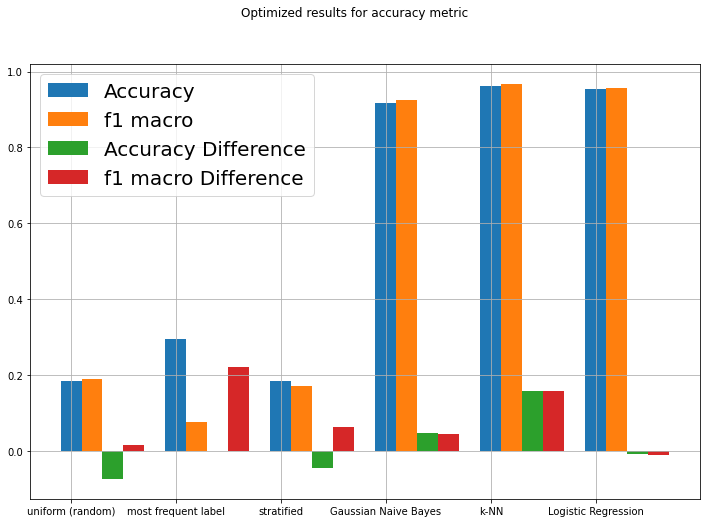

In [33]:
fig = plt.subplots(figsize=(12,8))

acc = metric_acc['accuracy'].values
f1 = metric_acc['f1 score'].values
acc_diff = metric_acc['accuracy difference'].values
f1_diff = metric_acc['f1 score difference'].values

barWidth = 0.2

bar_acc = np.arange(6)-barWidth/4
bar_f1 = [x+barWidth for x in bar_acc]
bar_acc_diff = [x+2*barWidth for x in bar_acc]
bar_f1_diff = [x+3*barWidth for x in bar_acc]

plt.bar(bar_acc, acc,width=barWidth, label='Accuracy')
plt.bar(bar_f1, f1,width=barWidth, label='f1 macro')
plt.bar(bar_acc_diff, acc_diff, width=barWidth, label='Accuracy Difference')
plt.bar(bar_f1_diff , f1_diff,width=barWidth, label='f1 macro Difference')
plt.xticks(np.array(bar_acc), np.array(models_names_new))
plt.legend(loc=2,prop={'size': 20})
plt.suptitle('Optimized results for accuracy metric')
plt.grid(True)
plt.show()

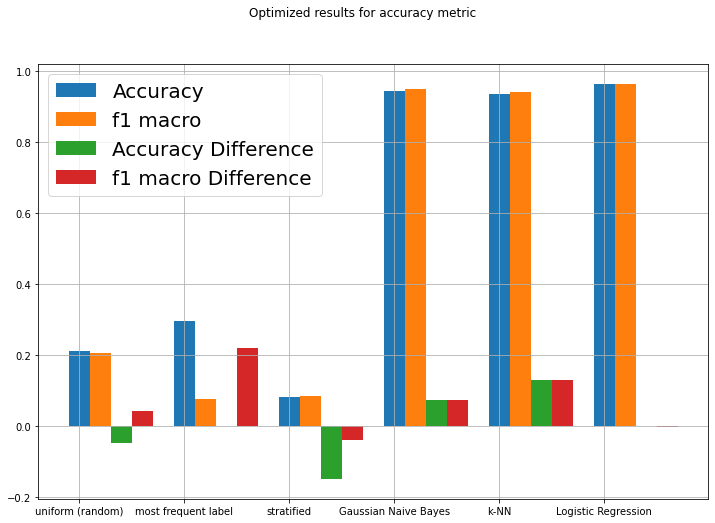

In [34]:
fig = plt.subplots(figsize=(12,8))

acc = metric_f1['accuracy'].values
f1 = metric_f1['f1 score'].values
acc_diff = metric_f1['accuracy difference'].values
f1_diff = metric_f1['f1 score difference'].values

barWidth = 0.2

bar_acc = np.arange(6)-barWidth/4
bar_f1 = [x+barWidth for x in bar_acc]
bar_acc_diff = [x+2*barWidth for x in bar_acc]
bar_f1_diff = [x+3*barWidth for x in bar_acc]

plt.bar(bar_acc, acc,width=barWidth, label='Accuracy')
plt.bar(bar_f1, f1,width=barWidth, label='f1 macro')
plt.bar(bar_acc_diff, acc_diff, width=barWidth, label='Accuracy Difference')
plt.bar(bar_f1_diff , f1_diff,width=barWidth, label='f1 macro Difference')
plt.xticks(np.array(bar_acc), np.array(models_names_new))
plt.legend(loc=2,prop={'size': 20})
plt.suptitle('Optimized results for accuracy metric')
plt.grid(True)
plt.show()

Είναι εμφανές, πως στην πλειοψηφία των μοντέλων μέσω τη βελτιστοποίησης καταλήγουμε σε καλύτερες τιμές accuracy , f1 score. Ωστόσο παρατηρούμε χειροτέρευση των αποτελεσμάτων στις περιπτώσεις του dummy-stratified και του logistic regression. Τα αποτελέσματα για το dummy-stratified είναι φυσιολογικά, καθώς επιλέγει βάσει αναλογίας κλάσεων, την οποία εξισορροπίσαμε μέσω του oversampling και έπειτα undersampling. Στην περίπτωση του most frequent label, δεν έχουμε κάποια διαφορά, καθώς τώρα που είναι ίσος ο αριθμός όλων των labels, επιλέγεται το label = 1 (επειδή είναι πρώτο στη σειρά), το οποίο προηγουμένως είχε τα περισσότερα δείγματα. Φαίνεται ότι στο συγκεκριμένο πρόβλημα η μέθοδος του logistic regression είναι αρκετά συμπαγής με αποτελέσμα γενικά να έχει παρόμοιες αποδόσεις (στη συγκεκριμένη περίπτωση τα πάει ελάχιστα χειρότερα μετά την βελτιστοποίηση).

Confusion matrix for Gaussian Naive Bayes model



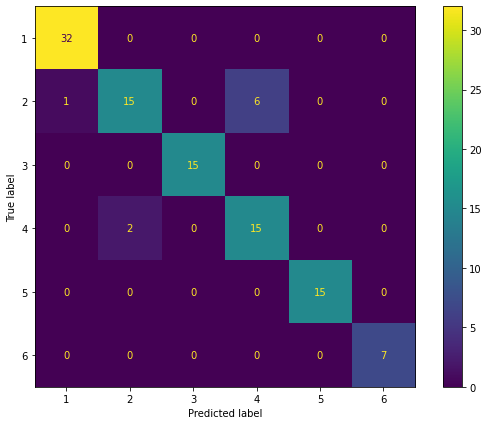



Confusion matrix for k-NN model



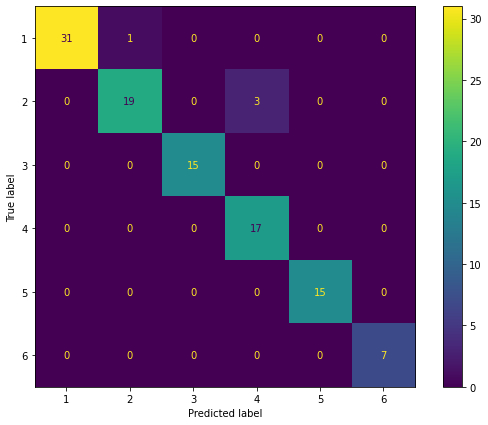



Confusion matrix for Logistic Regression model



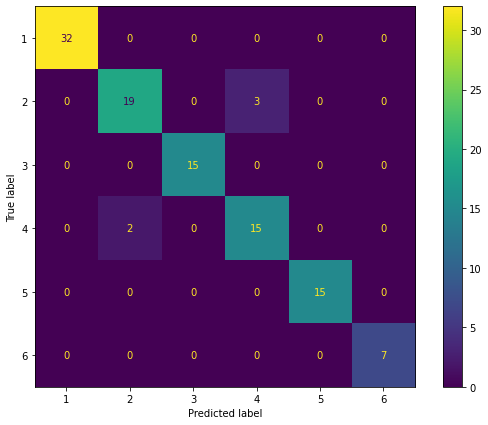

In [35]:
for name, preds in predictions.items():
    print('Confusion matrix for ' + str(name) + ' model')
    print()
    conf_matrix = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[1,2,3,4,5,6])
    plt.rcParams['figure.figsize'] = [10, 7]
    disp.plot()
    plt.show()
    print()
    print()

**Ποιον ταξινομητή προτείνετε τελικά για το συγκεκριμένο πρόβλημα και γιατί; Μπορείτε να δώσετε κάποια ερμηνεία για την καλή επίδοσή του στο πρόβλημα, απόλυτα ή/και σε σχέση με τους υπόλοιπους (εκτός των dummy);**


Θα επιλάγαμε να χρησιμοποιήσουμε την Logistic regression χωρίς την πραγματοποίηση βελτιστοποίησης καθώς δίνει τα καλύτερα αποτελέσματα accuracy και f1-score αλλά πιθανώς να χρησιμοποιήσαμε και βελτιστοποιημένο Gaussian Naive Bayes model το οποίο δίνει παραπλήσια αποτελέσματα ενώ παραμένει ταυτόχρονα και μια από τις πιο απλές μεθόδους μηχανικής μάθησης. Είναι μάλιστα λογικό οι 2 αυτές μέθοδοι να έχουν καλά αποτελέσματα για το dataset μας καθώς έχουμε ένα classification problem με κατηγορικές εισόδους. Ωστόσο και οι 3 "εξυπνες μέθοδοι δίνουν πολύ ικανοποιητικά και συγκρίσιμα αποτελέσματα άρα στην πράξη θα μπορούσε να επιλεχθει οποιαδήποτε από αυτές αν και σε περιπτωση που στο μέλλον αυξηθει σημαντικά ο αριθμός των δεδομένων , ο k-ΝΝ δεν ενδείκνεται.

# Μέρος 2. Kaggle Dataset

## Εισαγωγή Dataset

In [34]:
%%capture
drive.mount('/content/drive')

os.getcwd()
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab_Notebooks/Νευρωνικά Δίκτυα/kaggle'
os.chdir('/content/drive/MyDrive/Colab_Notebooks/Νευρωνικά Δίκτυα/kaggle')
!kaggle datasets download -d jsphyg/weather-dataset-rattle-package
os.listdir()

In [35]:
kaggle_df = pd.read_csv('weatherAUS.csv')
initial_data = kaggle_df.shape[0]
missing_labels = kaggle_df.RainTomorrow.isnull().sum()
kaggle_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


### Επισκόπηση

**Σύντομη παρουσίαση του dataset δηλαδή ποιο είναι το πρόβλημα που περιγράφει**

To συγκεκριμένο dataset περιγράφει την πρόγνωση βροχόπτωσης σε διάφορες περιοχές της Αυστραλίας. Επομένως σκόπος είναι η εκτίμηση του αν θα βρέξει ή όχι την επόμενη μέρα (θεωρείται ότι έβρεξε εάν η βρόχοπτωση ήταν περισσότερη από 1mm). Στο dataset περιέχονται δεδομένα καθημερινών καιρικών παρατηρήσεων 10 χρόνων, με κάθε δείγμα να έχει 22 διαφορετικά χαρακτηριστικά και τα τελικά labels.

**Χρειάστηκε να κάνετε μετατροπές στα αρχεία plain text για την εισαγωγή του; αν ναι, ποιες είναι αυτές;**

Όχι δεν χρειάστηκε να γίνει κάποια μετατροπή στο dataset κατα την εισαγωγή του.

**Δώστε το πλήθος δειγμάτων και χαρακτηριστικών, και το είδος όλων των χαρακτηριστικών. Υπάρχουν μη διατεταγμένα χαρακτηριστικά και ποια είναι αυτά;**



In [36]:
print('Number of instances = ' + str(kaggle_df.shape[0]))
print('Number of attributes = ' + str(kaggle_df.shape[1]))
print('Type of attributes: \n' + str(kaggle_df.dtypes))

Number of instances = 145460
Number of attributes = 23
Type of attributes: 
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


**Υπάρχουν επικεφαλίδες; Αρίθμηση γραμμών;**

Ναι υπάρχουν και επικεφαλίδες, ενώ η αρίθμηση γραμμών εισάγεται κατευθείαν από την βιβλιοθήκη pandas. Οι επικεδαλίδες είναι οι εξής:

In [37]:
kaggle_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

**Ποιες είναι οι ετικέτες των κλάσεων και σε ποια κολόνα βρίσκονται;**

Οι ετικέτες στον κλάσεων βρίσκονται στην κολόνα 'RainTommorow' και είναι 'Yes', 'No', δηλαδή εάν θα βρέξει ή όχι την επόμενη μέρα

**Υπάρχουν απουσιάζουσες τιμές; Πόσα είναι τα δείγματα με απουσιάζουσες τιμές και ποιο το ποσοστό τους επί του συνόλου;**

Υπάρχουν απουσιάζουσες σε διάφορες στήλες και σημειώνονται με NaN (Not a Number)


In [38]:
num_of_missing_data = kaggle_df.shape[0] - kaggle_df.dropna().shape[0]

print('Number of data with missing attributes = ' + str(num_of_missing_data))
print('Data with Missing attributes percentage = ' + str(round((num_of_missing_data / kaggle_df.shape[0]) * 100, 2)) + '%')

Number of data with missing attributes = 89040
Data with Missing attributes percentage = 61.21%


In [39]:
kaggle_df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Παρατηρούμε ότι για κάποια attributes υπάρχει πολύ μεγάλος αριθμός τιμών.

**Ποιος είναι το πλήθος των κλάσεων και τα ποσοστά δειγμάτων τους επί του συνόλου; Αν θεωρήσουμε ότι ένα dataset είναι μη ισορροπημένο αν μια οποιαδήποτε κλάση είναι 1.5 φορά πιο συχνή από κάποια άλλη (60%-40% σε binary datasets) εκτιμήστε αν το dataset είναι ισορροπημένο ή όχι.**

In [40]:
num_of_classes = len(kaggle_df['RainTomorrow'].unique())

rain = round((len(kaggle_df[kaggle_df.RainTomorrow == 'Yes']) / kaggle_df.shape[0]) * 100, 2)
no_rain = 100 - rain

print('Total number of classes = ' + str(num_of_classes))
print('Percentage of rain examples = ' + str(rain) + ' %')
print('Percentage of no rain examples = ' + str(no_rain) + ' %')

Total number of classes = 3
Percentage of rain examples = 21.91 %
Percentage of no rain examples = 78.09 %


In [41]:
if min(rain, no_rain) * 1.5 < max(rain, no_rain):
    print('The dataset is unbalanced')
else:
    print('The dataset is balanced')

The dataset is unbalanced


### Μετρικές

Επιλέγουμε να δουλέψουμε με το f1 score σαν κύρια μετρική, καθώς συνδιάζει τις τιμές precision και recall για να δώσει μία έγκυρη αξιολόγηση του μοντέλου μας, ειδικά εφόσον δουλεύουμε σε ένα unbalanced Dataset. 
$$f1_{score} = \frac{2 * precision * recall}{precision + recall}$$

## Προετοιμασία


Αρχικά αφαιρούμε όλα τα δεδομένα του dataset τα οποία έχουν απουσιάζουσες τιμές στην στήλη των labels δηλαδή στην RainTomorrow.

In [42]:
print('Initial number of data = ' + str(initial_data))
print('Missing values from labels columns = ' + str(missing_labels))
kaggle_df = kaggle_df.drop(kaggle_df.loc[kaggle_df.RainTomorrow.isnull()].index)
print('Dataset decrease after removing data without labels = ' + str(round(((1 - (kaggle_df.shape[0] / initial_data)) * 100), 2)) + ' %')

Initial number of data = 145460
Missing values from labels columns = 3267
Dataset decrease after removing data without labels = 2.25 %


Μετατρέπουμε όλες τις μη αριθμητικές τιμές σε αριθμητικές. Κρατάμε και ένα αντίγραφο του dataset για να πραγματοποιήσουμε άλλη προετοιμασία στην ενότητα της βελτιστοποίησης.

In [43]:
kaggle_df_simple = kaggle_df
kaggle_df_improved =copy.copy(kaggle_df)

In [44]:
cities = kaggle_df_simple['Location'].unique()
wind_dirs = kaggle_df_simple['WindGustDir'].unique()

location_mapping = {}

for i,city in enumerate(cities):
    location_mapping[city] = i
    
bool_mapping = {'Yes':1, 'No':0}
wind_dir_mapping = {'W':1, 'NNW':2, 'SE':3, 'ENE':4, 'SW':5,
                    'SSE':6, 'S':7, 'NE':8, 'SSW':9, 'N':10,
                    'WSW':11, 'ESE':12, 'E':13, 'NW':14, 'WWW':15, 'NNE':16}

kaggle_df_simple['Location'] = kaggle_df_simple['Location'].map(location_mapping)
kaggle_df_simple['WindGustDir'] = kaggle_df_simple['WindGustDir'].map(wind_dir_mapping)
kaggle_df_simple['WindDir9am'] = kaggle_df_simple['WindDir9am'].map(wind_dir_mapping)
kaggle_df_simple['WindDir3pm'] = kaggle_df_simple['WindDir3pm'].map(wind_dir_mapping)
kaggle_df_simple['RainToday'] = kaggle_df_simple['RainToday'].map(bool_mapping)
kaggle_df_simple['RainTomorrow'] = kaggle_df_simple['RainTomorrow'].map(bool_mapping)

Κάναμε για αρχή το πιο απλό map που γίνεται απο όλες τις τιμές που δεν είναι αριθμοί σε ints .Πιο περίπλοκα maps θα γίνουν στην βελτιστοποίηση.

Μετατρέψαμε τη στήλη Dates σε τρεις επιμέρους στήλες years,months,days γιατί αν μετατρέπαμε απλά την κάθε ημερομηνία σε έναν αριθμό, ο αριθμός αυτός θα ήταν πολύ μεγαλύτερης κλίμακας σε σχέση με την κλίμακα των υπόλοιπων attribute και το month που έχει και την μεγαλύτερη σημασία δεν θα βρισκόταν στα ψηφία με την μεγαλύτερη βαρύτητα.

In [45]:
dates = kaggle_df_simple['Date'].str.replace("-","").astype(int).values - 20000000
month_days = np.remainder(dates, 10000)
months = np.round(month_days / 100, 0)
days = np.remainder(month_days, 100)

kaggle_df_simple['Years'] = np.round(dates / 10000, 0)
kaggle_df_simple['Months'] = months
kaggle_df_simple['Days'] = days
kaggle_df_simple = kaggle_df_simple.drop('Date', axis = 1)

In [46]:
kaggle_df_simple = kaggle_df_simple[["Years", "Months", "Days", "Location", "MinTemp", "MaxTemp", "Rainfall", "Evaporation",
       "Sunshine", "WindGustDir", "WindGustSpeed", "WindDir9am", "WindDir3pm",
       "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm",
       "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "Temp9am",
       "Temp3pm", "RainToday", "RainTomorrow"]]

Τέλος αντικαθιστούμε όλες τις υπόλοιπες απουσίαζουσες τιμές με τις μέσες τιμές του attribute που αντιστοιχούν.

In [47]:
kaggle_df_simple.replace('nan',np.NaN,inplace=True)
imp=SimpleImputer(missing_values=np.NaN,strategy='mean')
kaggle_df_simple = pd.DataFrame(imp.fit_transform(kaggle_df_simple), columns = kaggle_df_simple.columns, index = kaggle_df_simple.index)
kaggle_df_simple

,Years,Months,Days,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,8.0,12.0,1.0,0.0,13.4,22.9,0.6,5.469824,7.624853,1.000000,44.0,1.0,7.811304,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,0.0,0.0
1,8.0,12.0,2.0,0.0,7.4,25.1,0.0,5.469824,7.624853,7.902009,44.0,2.0,11.000000,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,0.0,0.0
2,8.0,12.0,3.0,0.0,12.9,25.7,0.0,5.469824,7.624853,11.000000,46.0,1.0,11.000000,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,0.0,0.0
3,8.0,12.0,4.0,0.0,9.2,28.0,0.0,5.469824,7.624853,8.000000,24.0,3.0,13.000000,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,0.0,0.0
4,8.0,12.0,5.0,0.0,17.5,32.3,1.0,5.469824,7.624853,1.000000,41.0,4.0,14.000000,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,17.0,6.0,20.0,48.0,3.5,21.8,0.0,5.469824,7.624853,13.000000,31.0,12.0,13.000000,15.0,13.0,59.0,27.0,1024.7,1021.2,4.437189,4.503167,9.4,20.9,0.0,0.0
145455,17.0,6.0,21.0,48.0,2.8,23.4,0.0,5.469824,7.624853,13.000000,31.0,3.0,4.000000,13.0,11.0,51.0,24.0,1024.6,1020.3,4.437189,4.503167,10.1,22.4,0.0,0.0
145456,17.0,6.0,22.0,48.0,3.6,25.3,0.0,5.469824,7.624853,2.000000,22.0,3.0,10.000000,13.0,9.0,56.0,21.0,1023.5,1019.1,4.437189,4.503167,10.9,24.5,0.0,0.0
145457,17.0,6.0,23.0,48.0,5.4,26.9,0.0,5.469824,7.624853,10.000000,37.0,3.0,7.811304,9.0,9.0,53.0,24.0,1021.0,1016.8,4.437189,4.503167,12.5,26.1,0.0,0.0


In [48]:
kaggle_df_simple['RainTomorrow'] = kaggle_df_simple.RainTomorrow.replace('Yes', 1)
kaggle_df_simple['RainTomorrow'] = kaggle_df_simple.RainTomorrow.replace('No', 0)
kaggle_df_simple['RainTomorrow'] = kaggle_df_simple['RainTomorrow'].astype(int)

Επιλέγουμε tain / test split = 90 / 10, καθώς το dataset είναι αρκετά μεγάλο οπότε και με το 10 % του dataset ως test set είμαστε καλλυμένοι και έχουμε και περισσότερα δεδομένα για εκπαίδευση. To σχήμα cross-validation Που θα χρησιμοποιήσουμε είναι 5-fold cross-validation αφού το μεγάλο μέγεθος του dataset καθυστά μεγαλύτερα k περιττά.

In [49]:
data = kaggle_df_simple.values
features = data[:,:-1]
labels = data[:,-1]
x_train_base, x_test_base, y_train_base, y_test_base = train_test_split(features, labels, test_size=0.1, shuffle=True)

print(f'Train data shape: {x_train_base.shape}')
print(f'Train labels shape: {y_train_base.shape}')
print(f'Test data shape: {x_test_base.shape}')
print(f'Test labels shape: {y_test_base.shape}')

Train data shape: (127973, 24)
Train labels shape: (127973,)
Test data shape: (14220, 24)
Test labels shape: (14220,)


## Ταξινομητές

### Επίδοση Out-of-the-box

In [59]:
final_preds={}
final_preds_helper ={} #gia sullogi apotelesmaton

In [60]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

In [61]:
mlp_base = MLPClassifier()
svc_linear_base = SVC(kernel='linear')
svc_rbf_base = SVC(kernel='rbf')

In [62]:
kaggle_base_accuracy = {}
models_names = ['uniform (random)','most frequent label', 'stratified', 'mlp_base']
models = [dc_uniform, dc_most_frequent, dc_stratified, mlp_base ]

for model_name, model in zip(models_names, models):
  model = model.fit(x_train_base, y_train_base)
  preds = model.predict(x_test_base)
  kaggle_base_accuracy[model_name] = (model.score(x_test_base, y_test_base), f1_score(preds, y_test_base, average='macro'))
  print(model_name)
  if model_name == 'mlp_base' :
    final_preds_helper[model_name] = preds
    final_preds[model_name] = [f1_score(preds, y_test_base, average='macro'),model.score(x_test_base, y_test_base)]

  


uniform (random)
most frequent label
stratified
mlp_base


Λόγω τις τεράστιας χρονικής πολυπλοκότητας των SVM σε συνάρτηση με τον αριθμό των δειγμάτων(Ν^4) και λόγω της δυσκολίας μας να αποκτήσουμε πρόσβαση σε υπερυπολογιστή , είναι μάλλον αδύνατο να εκπαιδεύσουμε το SVM με ολόκληρο το dataset . Για αυτό θα πραγματοποίσουμε ένα undersampling με το 15% των δεδομένων , κρατώντας όμως σταθερή την αναλογία των κλάσεων.

In [63]:
sampled_df_15 = kaggle_df_simple.groupby('RainTomorrow', group_keys=False).apply(lambda x: x.sample(frac=0.15))
rain_percentage = round((len(sampled_df_15[sampled_df_15.RainTomorrow == 1]) / sampled_df_15.shape[0]) * 100, 2)

print('Number of sampled data = ' + str(sampled_df_15.shape[0]))
print('Percentage of rain examples in sampled data = ' + str(rain_percentage) + ' %')
print('Percentage of no rain examples in sampled dat = ' + str(100 - rain_percentage) + ' %')

Number of sampled data = 21329
Percentage of rain examples in sampled data = 22.42 %
Percentage of no rain examples in sampled dat = 77.58 %


Επιλέγουμε train/test split = 80/20 μιας για την μελέτη των υπερπαραμέτρων μιας και μειώθηκε το dataset.

In [64]:
data_sampled_15 = sampled_df_15.values
features_sampled_15 = data_sampled_15[:,:-1]
labels_samlped_15 = data_sampled_15[:,-1]
x_train_sampled_15, x_test_sampled_15, y_train_sampled_15, y_test_sampled_15 = train_test_split(features_sampled_15, labels_samlped_15, test_size=0.2, shuffle=True)

print(f'Train data shape: {x_train_sampled_15.shape}')
print(f'Train labels shape: {y_train_sampled_15.shape}')
print(f'Test data shape: {x_test_sampled_15.shape}')
print(f'Test labels shape: {y_test_sampled_15.shape}')

Train data shape: (17063, 24)
Train labels shape: (17063,)
Test data shape: (4266, 24)
Test labels shape: (4266,)


In [65]:

models_names = ['svc_linear_base','svc_rbf_base']
models = [svc_linear_base, svc_rbf_base]

for model_name, model in zip(models_names, models):
  model = model.fit(x_train_sampled_15, y_train_sampled_15)
  preds = model.predict(x_test_sampled_15)
  kaggle_base_accuracy[model_name] = (model.score(x_test_sampled_15, y_test_sampled_15), f1_score(preds, y_test_sampled_15, average='macro'))
  print(model_name)
  final_preds_helper[model_name] = preds
  final_preds[model_name] = [f1_score(preds, y_test_sampled_15, average='macro'),model.score(x_test_sampled_15, y_test_sampled_15)]
print("Classification Accuracy on the Dataset \n")
sorted_accuracy = [(k[0], kaggle_base_accuracy[k[0]]) for k in sorted(kaggle_base_accuracy.items(), key=lambda x: x[1][0], reverse=True)]
sorted_f1 = [(k[0], kaggle_base_accuracy[k[0]]) for k in sorted(kaggle_base_accuracy.items(), key=lambda x: x[1][1], reverse=True)]

for k, v in sorted_accuracy:
  print(k)
  print(f'Accuracy: {v[0]}')
  print(f'f1 (macro): {v[1]} \n')

print('Depending on accuracy: ')
for k, _ in sorted_accuracy:
  print(k, end = " ")
  if k != sorted_accuracy[-1][0]:
    print(">", end = " ")


print('\n \nDepending on f1: ')
for k, _ in sorted_f1:
  print(k, end = " ")
  if k != sorted_f1[-1][0]:
    print(">", end = " ")
print()

svc_linear_base
svc_rbf_base
Classification Accuracy on the Dataset 

mlp_base
Accuracy: 0.8386075949367089
f1 (macro): 0.709149923678692 

svc_linear_base
Accuracy: 0.8363806844819504
f1 (macro): 0.7340760030864197 

svc_rbf_base
Accuracy: 0.7845757149554617
f1 (macro): 0.5021890352816948 

most frequent label
Accuracy: 0.770464135021097
f1 (macro): 0.4351763584366063 

stratified
Accuracy: 0.6523909985935302
f1 (macro): 0.49975166953655187 

uniform (random)
Accuracy: 0.4989451476793249
f1 (macro): 0.4598284097000065 

Depending on accuracy: 
mlp_base > svc_linear_base > svc_rbf_base > most frequent label > stratified > uniform (random) 
 
Depending on f1: 
svc_linear_base > mlp_base > svc_rbf_base > stratified > uniform (random) > most frequent label 


,Accuracy,F1 score (macro)
uniform,0.498945,0.459828
most frequent label,0.770464,0.435176
stratified,0.652391,0.499752
mlp_base,0.838608,0.709150
svc_linear_base,0.836381,0.734076
svc_rbf_base,0.784576,0.502189


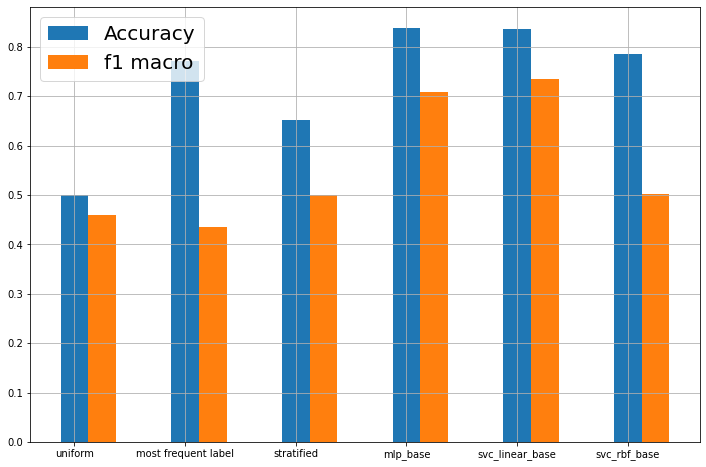

In [66]:
fig = plt.subplots(figsize=(12,8))
accuracy = [x for (x,_) in list(kaggle_base_accuracy.values())]
f1 = [x for (_,x) in list(kaggle_base_accuracy.values())]

barWidth = 0.25

bar_acc = np.arange(len(accuracy))-barWidth/4
bar_f1 = [x+barWidth for x in bar_acc]
models_names = ['uniform','most frequent label', 'stratified','mlp_base','svc_linear_base','svc_rbf_base']
plt.bar(bar_acc, accuracy,width=barWidth, label='Accuracy')
plt.bar(bar_f1, f1,width=barWidth, label='f1 macro')
plt.xticks(np.array(bar_acc), np.array(models_names))
plt.legend(loc=2,prop={'size': 20})
plt.grid(True)

out_of_the_box_kaggle_df = pd.DataFrame()
out_of_the_box_kaggle_df['Accuracy'] = pd.Series(accuracy)
out_of_the_box_kaggle_df['F1 score (macro)'] = pd.Series(f1)
out_of_the_box_kaggle_df.index = models_names
out_of_the_box_kaggle_df

Σχολιασμός

### Βελτιστοποίηση

Θα γίνει αναζήτηση στο χώρο υπερπαραμέτρων μέσω Optuna για την εύρεση των υπερπαραμέτρων που μεγιστοποίουν την μετρική που επιλέξαμε ($f1_{score}$  macro). Η προεπεξεργασία των δεδομένων γίνεται μέσω του Pipeline που ορίζουμε, το οποίο περιέχει scaler (για την κανονικοποίηση των δεδομένων λόγω διαφορετικής κλίμακας τιμών), random under sampler (καθώς το dataset μας δεν είναι ισορροπημένο) και pca (για την μείωση της διάστασης εισόδου η οποία είναι αρκετά μεγάλη).

Θα πραγματοποιήσουμε καλύτερη προεπεξεργασία του dataset. Συγκεκριμένα αντί να κανουμε απλά map τα attributes που δεν είναι ints or boolean και δεν είναι ταξινομήσιμα σε ints έτσι ώστε να μπορεί να τρέξει οι μεθόσοι μας, θα δημιουργήσουμε dummy attributes για καθε τιμή.

In [50]:
dates = kaggle_df_improved['Date'].str.replace("-","").astype(int).values - 20000000
month_days = np.remainder(dates, 10000)
months = np.round(month_days / 100, 0)
days = np.remainder(month_days, 100)

kaggle_df_improved['Years'] = np.round(dates / 10000, 0)
kaggle_df_improved['Months'] = months
kaggle_df_improved['Days'] = days
kaggle_df_improved = kaggle_df_improved.drop('Date', axis = 1)
print(kaggle_df_improved)

       Location  MinTemp  MaxTemp  Rainfall  ...  RainTomorrow  Years Months  Days
0        Albury     13.4     22.9       0.6  ...            No    8.0   12.0     1
1        Albury      7.4     25.1       0.0  ...            No    8.0   12.0     2
2        Albury     12.9     25.7       0.0  ...            No    8.0   12.0     3
3        Albury      9.2     28.0       0.0  ...            No    8.0   12.0     4
4        Albury     17.5     32.3       1.0  ...            No    8.0   12.0     5
...         ...      ...      ...       ...  ...           ...    ...    ...   ...
145454    Uluru      3.5     21.8       0.0  ...            No   17.0    6.0    20
145455    Uluru      2.8     23.4       0.0  ...            No   17.0    6.0    21
145456    Uluru      3.6     25.3       0.0  ...            No   17.0    6.0    22
145457    Uluru      5.4     26.9       0.0  ...            No   17.0    6.0    23
145458    Uluru      7.8     27.0       0.0  ...            No   17.0    6.0    24

[14

In [51]:
kaggle_df_improved = kaggle_df_improved[["Years", "Months", "Days", "Location", "MinTemp", "MaxTemp", "Rainfall", "Evaporation",
       "Sunshine", "WindGustDir", "WindGustSpeed", "WindDir9am", "WindDir3pm",
       "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm",
       "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "Temp9am",
       "Temp3pm", "RainToday", "RainTomorrow"]]

In [52]:
bool_mapping = {'Yes':1, 'No':0}
kaggle_df_improved['RainToday'] = kaggle_df_improved['RainToday'].map(bool_mapping)
kaggle_df_improved['RainTomorrow'] = kaggle_df_improved['RainTomorrow'].map(bool_mapping)

In [53]:
kaggle_df_improved = pd.get_dummies(kaggle_df_improved, columns=['Location','WindGustDir','WindDir9am','WindDir3pm']).apply(pd.to_numeric)
print(kaggle_df_improved)

        Years  Months  Days  ...  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW
0         8.0    12.0     1  ...             0               1               0
1         8.0    12.0     2  ...             0               0               1
2         8.0    12.0     3  ...             0               0               1
3         8.0    12.0     4  ...             0               0               0
4         8.0    12.0     5  ...             0               0               0
...       ...     ...   ...  ...           ...             ...             ...
145454   17.0     6.0    20  ...             0               0               0
145455   17.0     6.0    21  ...             0               0               0
145456   17.0     6.0    22  ...             0               0               0
145457   17.0     6.0    23  ...             0               1               0
145458   17.0     6.0    24  ...             0               0               0

[142193 rows x 118 columns]


In [54]:
kaggle_df_improved.replace('nan',np.NaN,inplace=True)
imp=SimpleImputer(missing_values=np.NaN,strategy='mean')
kaggle_df_improved = pd.DataFrame(imp.fit_transform(kaggle_df_improved), columns = kaggle_df_improved.columns, index = kaggle_df_improved.index)
kaggle_df_improved

,Years,Months,Days,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,...,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,8.0,12.0,1.0,13.4,22.9,0.6,5.469824,7.624853,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,8.0,12.0,2.0,7.4,25.1,0.0,5.469824,7.624853,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8.0,12.0,3.0,12.9,25.7,0.0,5.469824,7.624853,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,8.0,12.0,4.0,9.2,28.0,0.0,5.469824,7.624853,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,12.0,5.0,17.5,32.3,1.0,5.469824,7.624853,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,17.0,6.0,20.0,3.5,21.8,0.0,5.469824,7.624853,31.0,15.0,13.0,59.0,27.0,1024.7,1021.2,4.437189,4.503167,9.4,20.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145455,17.0,6.0,21.0,2.8,23.4,0.0,5.469824,7.624853,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,4.437189,4.503167,10.1,22.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [55]:
data = kaggle_df_improved.values
features = data[:,:-1]
labels = data[:,-1]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=True)

print(f'Train data shape: {x_train.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Test data shape: {x_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Train data shape: (127973, 117)
Train labels shape: (127973,)
Test data shape: (14220, 117)
Test labels shape: (14220,)


#### Multy-Layer Perceptron

Οι υπερπαράμετροι του MLP που θα μελετηθούν είναι οι εξής : 

*   learning rate : Αποτελεί την σημαντικότερη υπερπαράμετρο για έναν MLP και για τον λόγο αυτό θα μελετηθεί τόσο η αρχική τιμή του στο διάστημα (0.0005, 0.005) (default τιμή = 0.001), όσο και ο τύπος του learning rate (constant - παραμένει σταθερό, adaptive - μειώνεται αν δεν βελτιώνεται η εκπαίδευση).

*   functional units : Μελετάμε τιμές στο διάστημα [100, 250], καθώς η default τιμή είναι 100 και αυξάνοντας τον αριθμό των functional unit ευελπιστούμε σε αύξηση της επίδοσης. 

*   activation function : Το συγκεκριμένο πρόβλημα είναι ένα binary classification πρόβλημα οπότε μελετάμε τα activation functions = tanh, logistic (sigmoid), τα οποία είναι τα πιο ταιριαστά για τέτοιο τύπου προβλήματος.

*   alpha : Με σκοπό την αποφυγή overfitting θα μελετηθούν διαφορετικές τιμές penalty (alpha) κατά το regularization.

Επιλέγουμε 2 hidden layers (πιο βαθύ νευρωνικό από το default που περιέχει 1 hidden layer) και όσον αφορά τα max iterations επιλέγουμε μεγάλο αριθμό επαναλήψεων και χρησιμοποιούμε early stopping, το οποίο σταματάει την διαδικασία εκπαίδευσης όταν η απόδοση στο testing set σταματάει να βελτιώνεται (αποφεύγοντας έτσι το overfitting).  

In [102]:
def mlp_objective(trial):

    scaler = StandardScaler()
    rus = RandomUnderSampler()

    #components = trial.suggest_int('pca_components', 10, 22)
    #pca = PCA(n_components= components)

    lr_types = trial.suggest_categorical('lr_type', ['constant', 'adaptive'])
    learning_rates = trial.suggest_float('learning_rate',  0.0005, 0.01, step = 0.0001)
    alphas = trial.suggest_float('alpha', 1e-5, 1e-1, step = 1e-6)
    activations = trial.suggest_categorical('activation', ['logistic', 'relu'])
    solvers = trial.suggest_categorical('solver', ['lbfgs', 'adam'])

    layers_sizes = []
    for i in range(2):
        layers_sizes.append(trial.suggest_int(f'n_units_{i}', 100, 250, step = 10))

    clf = MLPClassifier(hidden_layer_sizes=tuple(layers_sizes), activation = activations, solver = solvers,
                        max_iter = 300, learning_rate_init = learning_rates,
                        learning_rate = lr_types, early_stopping = True)
    
    pipe = Pipeline(steps=[('scaler', scaler), ('sampler', rus),  ('mlp', clf)])
    
    pipe.fit(x_train, y_train)
    preds = pipe.predict(x_test)
    goal = f1_score(y_test,preds, average= 'macro')

    return goal

In [103]:
mlp_study = optuna.create_study(direction='maximize')
mlp_study.optimize(mlp_objective, n_trials=100)

[I 2021-11-30 10:41:01,469] A new study created in memory with name: no-name-bff4eaa1-ef75-40b1-a7a5-e0baf7f9d5f2
[I 2021-11-30 10:41:11,974] Trial 0 finished with value: 0.9574992926511435 and parameters: {'lr_type': 'adaptive', 'learning_rate': 0.0051, 'alpha': 0.002662, 'activation': 'logistic', 'solver': 'adam', 'n_units_0': 130, 'n_units_1': 250}. Best is trial 0 with value: 0.9574992926511435.
[I 2021-11-30 10:41:24,455] Trial 1 finished with value: 0.9655699861380181 and parameters: {'lr_type': 'constant', 'learning_rate': 0.0074, 'alpha': 0.024163999999999998, 'activation': 'logistic', 'solver': 'adam', 'n_units_0': 100, 'n_units_1': 240}. Best is trial 1 with value: 0.9655699861380181.
[I 2021-11-30 10:42:32,178] Trial 2 finished with value: 0.9603285089601215 and parameters: {'lr_type': 'adaptive', 'learning_rate': 0.0023, 'alpha': 0.038698, 'activation': 'logistic', 'solver': 'lbfgs', 'n_units_0': 240, 'n_units_1': 230}. Best is trial 1 with value: 0.9655699861380181.
[I 202

In [104]:
optuna.visualization.plot_optimization_history(mlp_study)

Πραγματοποιούμε ένα πολύ μικρό gridsearch και 10-fold cross-validation για με παραμέτρους των τριών καλύτερων trial (27, 33, 97) της optuna. Για να πραγματοποιηθεί γρηγορότερα το Gridsearch, από τις παραμέτρους που είναι πάρα πολύ κοντινές οι τιμές του παίρνουμε μία τιμή.

In [150]:
mlp_study.best_trial.params

{'activation': 'logistic',
 'alpha': 0.051406,
 'learning_rate': 0.0086,
 'lr_type': 'constant',
 'n_units_0': 120,
 'n_units_1': 200,
 'solver': 'adam'}

In [151]:
optuna.trial.Trial(mlp_study, 8).params

{'activation': 'logistic',
 'alpha': 0.018556999999999997,
 'learning_rate': 0.0045000000000000005,
 'lr_type': 'adaptive',
 'n_units_0': 110,
 'n_units_1': 190,
 'solver': 'adam'}

In [152]:
optuna.trial.Trial(mlp_study, 10).params

{'activation': 'logistic',
 'alpha': 0.034504,
 'learning_rate': 0.01,
 'lr_type': 'constant',
 'n_units_0': 140,
 'n_units_1': 110,
 'solver': 'adam'}

Διαλέγουμε 3 από τα καλύτερα trial και κάνμουμε grid search στις παραμέτρους τους

In [56]:
scaler = StandardScaler()
rus = RandomUnderSampler()

clf = MLPClassifier(activation = 'logistic',  max_iter = 300, learning_rate = 'constant', early_stopping = True, solver='adam')
    
pipe = Pipeline(steps=[('scaler', scaler), ('sampler', rus), ('mlp', clf)])

lrs = [0.005, 0.01]
alphas = [0.03, 0.06]
layer_sizes = [(200,120), (140, 110)]

params_grid = {'mlp__learning_rate_init': lrs,
               'mlp__alpha': alphas,
               'mlp__hidden_layer_sizes': layer_sizes,
               }

estimator = GridSearchCV(pipe, params_grid, cv=5, scoring='f1_macro')
estimator.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('mlp',
                                        MLPClassifier(activation='logistic',
                                                      early_stopping=True,
                                                      max_iter=300))]),
             param_grid={'mlp__alpha': [0.03, 0.06],
                         'mlp__hidden_layer_sizes': [(200, 120), (140, 110)],
                         'mlp__learning_rate_init': [0.005, 0.01]},
             scoring='f1_macro')

In [67]:
preds = estimator.predict(x_test)
final_preds_helper['mlp_improved'] = preds
final_preds['mlp_improved'] =[f1_score(y_test, preds, average='macro'),accuracy_score(preds, y_test)]
print(f'Best parameters: {estimator.best_params_}')
print()
print('F1 score (macro) ' + str(f1_score(y_test, preds, average='macro')))
print(f'Accuracy: {accuracy_score(preds, y_test)}')

Best parameters: {'mlp__alpha': 0.03, 'mlp__hidden_layer_sizes': (140, 110), 'mlp__learning_rate_init': 0.01}

F1 score (macro) 0.9659215996960782
Accuracy: 0.990857946554149


#### Support Vector Machines

Για τα SVMs χρειάζεται να μειωθεί το μέγεθος του dataset ακόμα περισσότερο καθώς τώρα με το optuna θα πραγματοποιήσουμε 300 trials. Ετσι κάνουμε resample στο 10% του αρχικού dataset για την μελέτη του χώρου υπερπαραμέτρων κρατώντας όμως σταθερή την αναλογία των κλάσεων.

In [88]:
sampled_df_10 = kaggle_df_improved.groupby('RainTomorrow', group_keys=False).apply(lambda x: x.sample(frac=0.1))
rain_percentage = round((len(sampled_df_10[sampled_df_10.RainTomorrow == 1]) / sampled_df_10.shape[0]) * 100, 2)

print('Number of sampled data = ' + str(sampled_df_10.shape[0]))
print('Percentage of rain examples in sampled data = ' + str(rain_percentage) + ' %')
print('Percentage of no rain examples in sampled dat = ' + str(100 - rain_percentage) + ' %')

Number of sampled data = 14220
Percentage of rain examples in sampled data = 22.42 %
Percentage of no rain examples in sampled dat = 77.58 %


Επιλέγουμε train/test split = 80/20 μιας για την μελέτη των υπερπαραμέτρων μιας και μειώθηκε το dataset.

In [89]:
data_sampled_10 = sampled_df_10.values
features_sampled_10 = data_sampled_10[:,:-1]
labels_samlped_10 = data_sampled_10[:,-1]
x_train_sampled_10, x_test_sampled_10, y_train_sampled_10, y_test_sampled_10 = train_test_split(features_sampled_10, labels_samlped_10, test_size=0.2, shuffle=True)

print(f'Train data shape: {x_train_sampled_10.shape}')
print(f'Train labels shape: {y_train_sampled_10.shape}')
print(f'Test data shape: {x_test_sampled_10.shape}')
print(f'Test labels shape: {y_test_sampled_10.shape}')

Train data shape: (11376, 117)
Train labels shape: (11376,)
Test data shape: (2844, 117)
Test labels shape: (2844,)


In [90]:
def svc_objective(trial):

    scaler = StandardScaler()
    rus = RandomUnderSampler()

    components = trial.suggest_int('pca_components', 114, 117)

    pca = PCA(n_components= components)

    params = {
        'C': trial.suggest_loguniform('C',1e-4, 100),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e4),
        'kernel': trial.suggest_categorical("kernel", ["rbf","linear"])
    }

    clf = SVC(**params)
    
    pipe = Pipeline(steps=[ ('scaler', scaler),  ('sampler', rus), ('pca', pca),('svc', clf)])
    
    pipe.fit(x_train_sampled_10, y_train_sampled_10)
    preds = pipe.predict(x_test_sampled_10)
    goal = f1_score(y_test_sampled_10,preds, average= 'macro')

    return goal

In [91]:
svc_study = optuna.create_study(direction='maximize')
svc_study.optimize(svc_objective, n_trials=300)

[I 2021-11-30 12:42:08,645] A new study created in memory with name: no-name-39562384-6794-4ae7-8118-1bd40f672c23
[I 2021-11-30 12:42:09,233] Trial 0 finished with value: 0.9371986721331989 and parameters: {'pca_components': 115, 'C': 0.10634642642188537, 'gamma': 486.3733331619925, 'kernel': 'linear'}. Best is trial 0 with value: 0.9371986721331989.
[I 2021-11-30 12:42:10,163] Trial 1 finished with value: 0.06124690043851618 and parameters: {'pca_components': 114, 'C': 0.5848316765191913, 'gamma': 437.5764585484626, 'kernel': 'rbf'}. Best is trial 0 with value: 0.9371986721331989.
[I 2021-11-30 12:42:11,119] Trial 2 finished with value: 0.4446457999134963 and parameters: {'pca_components': 115, 'C': 0.2444467976180649, 'gamma': 0.050617813592433815, 'kernel': 'rbf'}. Best is trial 0 with value: 0.9371986721331989.
[I 2021-11-30 12:42:11,337] Trial 3 finished with value: 0.9319652281442987 and parameters: {'pca_components': 115, 'C': 0.6978309361114212, 'gamma': 0.33930156940771006, 'k

In [92]:
optuna.visualization.plot_optimization_history(svc_study)

Διαλέγουμε 3 από τα καλύτερα trial.

In [95]:
svc_study.best_trial.params

{'C': 0.5897017446645638,
 'gamma': 0.2111157997898418,
 'kernel': 'linear',
 'pca_components': 117}

In [93]:
optuna.trial.Trial(svc_study, 234).params

{'C': 0.6773028185586154,
 'gamma': 0.20301892479611974,
 'kernel': 'linear',
 'pca_components': 117}

In [94]:
optuna.trial.Trial(svc_study, 284).params

{'C': 0.35927403231978333,
 'gamma': 0.04766569260478588,
 'kernel': 'linear',
 'pca_components': 117}

Παρατηρούμε πως στα καλύτερα trials o pca κρατάει πρακτικα σχεδον όλα τα attributes άρα είναι περιττός και πως το C παίρνει τιμές από 0.3 εως 0.7 και το gamma από 0.04 εώς 0.3. Επίσης μετά από δοκιμές ούτε ο undersampler φαίνεται να βοηθά άρα αφαιρείται. Επίσης όλα τα καλά αποτελέσματα ήταν για linear kernel. Ξανατρέχουμε optuna έχοντας περιορίσει τους χώρους αναζήτησης.

In [96]:
def svc_objective(trial):

    scaler = StandardScaler()
    rus = RandomUnderSampler()

    

    params = {
        'C': trial.suggest_loguniform('C',0.3, 1),
        'gamma': trial.suggest_loguniform('gamma', 0.03, 0.3),
        'kernel': trial.suggest_categorical("kernel", ["linear"])
    }

    clf = SVC(**params)
    
    pipe = Pipeline(steps=[ ('scaler', scaler),   ('svc', clf)])
    
    pipe.fit(x_train_sampled_10, y_train_sampled_10)
    preds = pipe.predict(x_test_sampled_10)
    goal = f1_score(y_test_sampled_10,preds, average= 'macro')

    return goal

In [97]:
svc_study = optuna.create_study(direction='maximize')
svc_study.optimize(svc_objective, n_trials=100)

[I 2021-11-30 12:46:11,899] A new study created in memory with name: no-name-cee2fc10-d5dc-4954-977d-6d631c34891d
[I 2021-11-30 12:46:12,854] Trial 0 finished with value: 0.9747280738023042 and parameters: {'C': 0.3515765130259599, 'gamma': 0.08613263695920463, 'kernel': 'linear'}. Best is trial 0 with value: 0.9747280738023042.
[I 2021-11-30 12:46:13,811] Trial 1 finished with value: 0.9733108108108108 and parameters: {'C': 0.4456829718313906, 'gamma': 0.06124347404231223, 'kernel': 'linear'}. Best is trial 0 with value: 0.9747280738023042.
[I 2021-11-30 12:46:15,001] Trial 2 finished with value: 0.9701908664982655 and parameters: {'C': 0.8301736611718542, 'gamma': 0.03821246219448076, 'kernel': 'linear'}. Best is trial 0 with value: 0.9747280738023042.
[I 2021-11-30 12:46:16,022] Trial 3 finished with value: 0.9731717798484387 and parameters: {'C': 0.7481589573937903, 'gamma': 0.03534204030548002, 'kernel': 'linear'}. Best is trial 0 with value: 0.9747280738023042.
[I 2021-11-30 12:4

In [98]:
optuna.visualization.plot_optimization_history(svc_study)

Διαλέγουμε 3 από τα καλύτερα trial και κάνμουμε grid search στις παραμέτρους τους

In [99]:
svc_study.best_trial.params

{'C': 0.401621811541987, 'gamma': 0.1524766366227319, 'kernel': 'linear'}

In [100]:
optuna.trial.Trial(svc_study, 43).params

{'C': 0.39692759341464395, 'gamma': 0.23804353610045628, 'kernel': 'linear'}

In [101]:
optuna.trial.Trial(svc_study, 75).params

{'C': 0.3964908884141303, 'gamma': 0.07334537758968894, 'kernel': 'linear'}

Κανουμε και ένα grid search πάνω στις καλύτερες trials.

In [105]:
scaler = StandardScaler()

clf = SVC(kernel = 'linear')
    
pipe = Pipeline(steps=[('scaler', scaler),  ('svc', clf)])

Cs = [0.4]
gammas = [0.073, 0.23, 0.15]

params_grid = {'svc__C': Cs,
               'svc__gamma': gammas 
               }

estimator = GridSearchCV(pipe, params_grid, cv=10, scoring='f1_macro')
estimator.fit(x_train_sampled_10, y_train_sampled_10)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(kernel='linear'))]),
             param_grid={'svc__C': [0.4], 'svc__gamma': [0.073, 0.23, 0.15]},
             scoring='f1_macro')

In [106]:
preds = estimator.predict(x_test_sampled_10)
final_preds_helper['svm_improved'] = preds
final_preds['svm_improved'] = [f1_score(preds, y_test_sampled_10, average='macro'),accuracy_score(preds, y_test_sampled_10)]
print(f'Best parameters: {estimator.best_params_}')
print()
print('F1 score (macro) ' + str(f1_score(preds, y_test_sampled_10, average='macro')))
print(f'Accuracy: {accuracy_score(preds, y_test_sampled_10)}')

Best parameters: {'svc__C': 0.4, 'svc__gamma': 0.073}

F1 score (macro) 0.9762762762762763
Accuracy: 0.9943741209563994


In [107]:
final_results = pd.DataFrame()
final_results = pd.DataFrame.from_dict(final_preds, orient='index',columns=['f1_score','accuracy'])
  
print(final_results)

                 f1_score  accuracy
mlp_base         0.709150  0.838608
svc_linear_base  0.734076  0.836381
svc_rbf_base     0.502189  0.784576
mlp_improved     0.965922  0.990858
svm_improved     0.976276  0.994374


In [108]:
acc_results =[]
f1_results =[]
for name, res in final_preds.items():
  acc_results.append(res[1])
  f1_results.append(res[0])

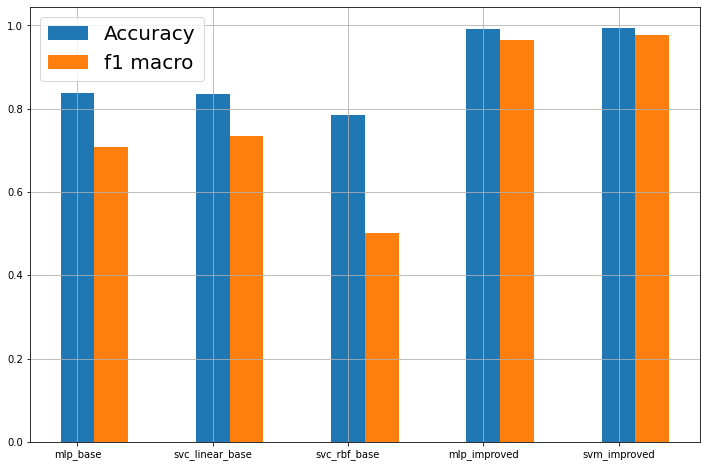

In [109]:
fig = plt.subplots(figsize=(12,8))


barWidth = 0.25

bar_acc = np.arange(len(acc_results))-barWidth/4
bar_f1 = [x+barWidth for x in bar_acc]
models_names = ['mlp_base','svc_linear_base','svc_rbf_base', 'mlp_improved', 'svm_improved']
plt.bar(bar_acc, acc_results,width=barWidth, label='Accuracy')
plt.bar(bar_f1, f1_results,width=barWidth, label='f1 macro')
plt.xticks(np.array(bar_acc), np.array(models_names))
plt.legend(loc=2,prop={'size': 20})
plt.grid(True)

Confusion matrix for  mlp_base



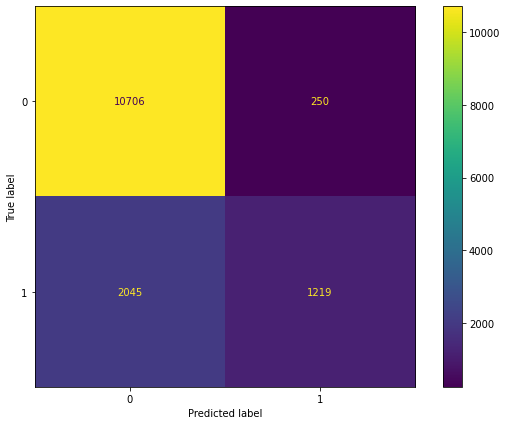

In [111]:
#mlp_base
print('Confusion matrix for  mlp_base')
print()
conf_matrix = confusion_matrix(y_test_base,final_preds_helper['mlp_base'] )
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0,1])
plt.rcParams['figure.figsize'] = [10, 7]
disp.plot()
plt.show()
print()
print()

Confusion matrix for  svc_linear_base



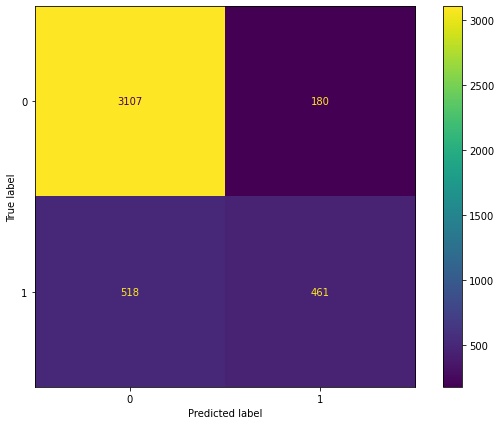

In [112]:
#svc_linear_base
print('Confusion matrix for  svc_linear_base')
print()
conf_matrix = confusion_matrix(y_test_sampled_15,final_preds_helper['svc_linear_base'] )
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0,1])
plt.rcParams['figure.figsize'] = [10, 7]
disp.plot()
plt.show()
print()
print()

Confusion matrix for  svc_rbf_base



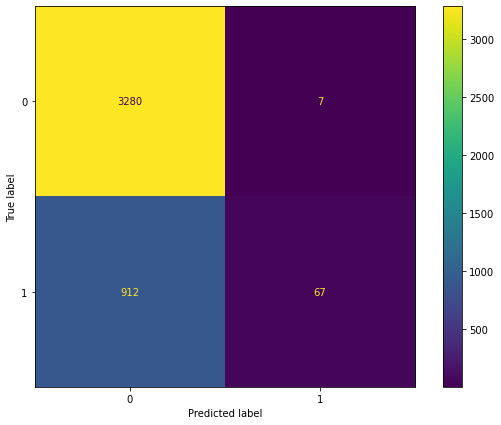

In [114]:
#svc_rbf_base
print('Confusion matrix for  svc_rbf_base')
print()
conf_matrix = confusion_matrix(y_test_sampled_15,final_preds_helper['svc_rbf_base'] )
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0,1])
plt.rcParams['figure.figsize'] = [10, 7]
disp.plot()
plt.show()
print()
print()

Confusion matrix for  svm_improved



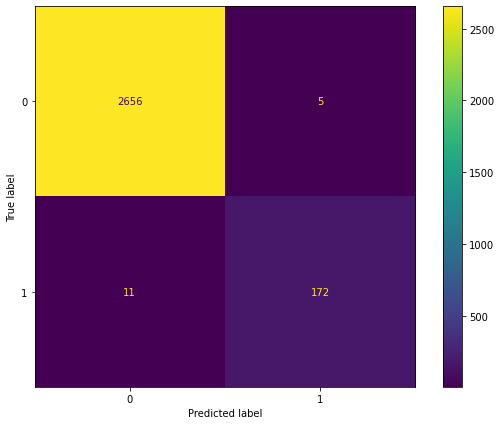

In [115]:
#svm_improved
print('Confusion matrix for  svm_improved')
print()
conf_matrix = confusion_matrix(y_test_sampled_10,final_preds_helper['svm_improved'] )
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0,1])
plt.rcParams['figure.figsize'] = [10, 7]
disp.plot()
plt.show()
print()
print()

Confusion matrix for  mlp_improved



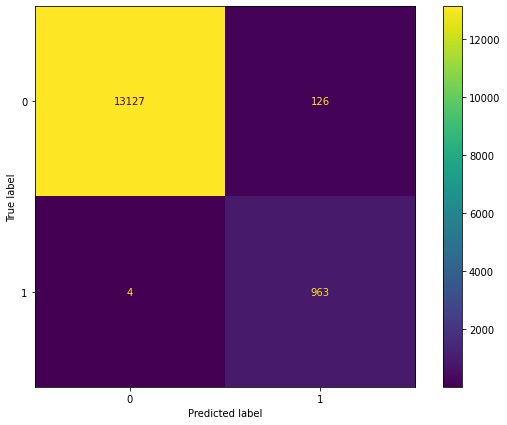

In [116]:
#mlp_improved
print('Confusion matrix for  mlp_improved')
print()
conf_matrix = confusion_matrix(y_test,final_preds_helper['mlp_improved'] )
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0,1])
plt.rcParams['figure.figsize'] = [10, 7]
disp.plot()
plt.show()
print()
print()